In [1]:
from result_processing import get_lira_scores, create_bins, \
    get_overall_tpr_at_fpr,  \
    get_attackr_scores
import pandas as pd
import einops

from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

plt.style.use('plot_style.mplstyle')


In [2]:
target_col = "lira_score"

base_col = "avg_norm"
levels = [0.1]

def get_metrics_set_for_k(plots, k, levels, avg_norm_plots, base_col="avg_norm", target_col="lira_score"):
    # avg_norm_plots = [x[0] for x in plots]
    plot_metrics = []
    for plot in plots:
        metrics_list = []
        # for metric in ["auc", "overall_tpr", "precision", "recall"]:
        for metric in ["auc", "overall_tpr", "precision", "recall","precision_on_union"]:
            # if target_col != base_col:
            f = plot[1]
            if f is not None:
                base_col = "avg_norm"
            else:
                base_col = plot[0]
            metrics_list.append(get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric))
        plot_metrics.append(metrics_list)
    return plot_metrics


In [3]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

In [4]:

def accuracy_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    top_attack = members.sort_values(attack_score, ascending=False)
    return len(set(top_attack.head(n)['og_idx']).intersection(set(top_score.head(n)['og_idx']))) / float(n)


def precision_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    
    threshold = thresholds[np.where(fprs <= level)[0][-1]]

    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)
    tp = sum(top_k[attack_score] >= threshold)

    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)


def recall_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    # if attack_score == "attackr_score":
    #     attack_scores = 1 - attack_scores
    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    threshold = thresholds[np.where(fprs <= level)[0][-1]]

    top_k = top_score.head(n)

    if random_guessing:
        return float(k)/100


    # if attack_score == "attackr_score":
    #     tp = sum(1-top_k[attack_score] >= threshold)
    #     neg = sum(1-members[attack_score] >= threshold)
    # else:
    tp = sum(top_k[attack_score] >= threshold)
    neg = sum(members[attack_score] >= threshold)

    return tp / neg if neg else 0

def precision_on_union(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    # if attack_score == "attackr_score":
    #     attack_scores = 1-attack_scores
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss attack']
    members = df[df['target_trained_on'] == True]
    members_dict = set()
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
        # if attack_score == "attackr_score":
        #     attack_scores = 1-attack_scores
            
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        print(attack_score, threshold)

        # if attack_score == "attackr_score":
        #     vulnerable =  members.loc[(1 - members[attack_score]) >= threshold]
        # else:
        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]  
        members_dict.update(vulnerable.index)

    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)
    # if attack_score=="attackr_score":
    #     tp = sum(1-top_k[attack_score] >= threshold)
    # else:
    tp = len(set(top_k.index) & members_dict)
    print(float(tp) / len(top_k), n, sum(members[attack_score] >= threshold))
    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)

    

In [5]:
from results.result_processing import get_trace_reduction

averaging_over_duals = True
cross_evals = True
# level = 0.00001
# exp_id = 'WRN28_10_CIFAR100'
# exp_id = 'WRN28_2_CINIC10'
# exp_id = "WRN40_4_CIFAR100"
exp_id = "wrn28-2_CIFAR10"
dual_count = 1

ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
# levels = np.linspace(0,1,15)
k=1
metric = "precision"


plots = [
    ('rmia_1', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_1", return_full_df=False)),
    (
        'final loss',
        lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
    ),
    (
        'loss iqr (75%-25%)',
        lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
    ),
]
avg_norm_plots = [x[0] for x in plots]

In [6]:
import sklearn

def get_dual_score(df, target_col, base_col, levels, k=1, metric="precision"):
    random_guessing = False
    if metric == "overall_tpr":
        return [get_overall_tpr_at_fpr(df, level, target_col=base_col) for level in levels]
    if metric == "auc":
        return [sklearn.metrics.roc_auc_score(df['target_trained_on'], df[base_col]) for level in levels]

    members = df[df['target_trained_on'] == True]
    # if base_col == "attackr_score":
    #     top_score = members.sort_values(base_col, ascending=True)
    if base_col == "random_guessing":
        top_score = members.sort_values("lira_score", ascending=False)
        random_guessing = True
    else:
        top_score = members.sort_values(base_col, ascending=False)

    if metric == "precision":
        metric_func = precision_at_k
    elif metric == "accuracy":
        metric_func = accuracy_at_k
    elif metric == "recall":
        metric_func = recall_at_k
    elif metric == "precision_on_union":
        metric_func = precision_on_union

    metrics = [metric_func(df, k, members, top_score, level, target_col, random_guessing) for level in levels]
    # print(metrics)
    if metric == "precision" or metric == "precision_on_union":
        return [x[0] for x in metrics]
    if metric == "n_points":
        return [x[:1] for x in metrics]
    if metric == "n_most_vulnerable":
        return [[x[1:]] for x in metrics]
    return metrics

In [7]:
from results.result_processing import get_rmia_scores


def get_dual_average(dual_count, exp_id, target_col, base_col,levels, f=None, k=1, metric="precision"):
    duals = []

    for d in range(dual_count):
        tag = f'dual_track_both_{d}' if dual_count > 1 else ''
        print(tag)
        df = get_lira_scores(exp_id)
                             # + "_checkpoint_before_100", f'dual_track_both_{d}')
        df['attackr_score'] = get_attackr_scores(exp_id + tag)
        df['rmia_score'] = get_rmia_scores(exp_id + tag)
        df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
        df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 
        # df['avg_norm'] = f(exp_id, f'dual_track_both_{d}')    # FROM SRC MODEL
        
        
        if f is not None:
            # print(base_col)
            df['avg_norm'] = f(exp_id, tag)
            df['norm_bin'] = create_bins(df)
            base_col = "avg_norm"

        duals.append([round(x, 3) for x in get_dual_score(df,target_col,base_col,levels, k, metric)])
    return einops.reduce(np.array(duals), "duals fprs -> fprs", reduction="mean")

In [8]:
def get_tpr_fpr_attack_comparison(dual_count, exp_id, k, levels,metric="precision"):
    metric_dict = {}
    for target_col in ["lira_score"]:
    # for target_col in ["attackr_score"]:
        plt.figure()
        metric_dict[target_col] = {}

        for idx, base_col in enumerate([x[0] for x in plots] + ["lira_score", "attackr_score", "rmia_score","random_guessing"]):
            if target_col != base_col:
                print(f"{target_col=}{base_col=}")
                f = None
                if base_col in avg_norm_plots:
                    f = plots[idx][1]
                tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                metric_dict[target_col][base_col] = tpr
        return metric_dict
    
label_mapping = {"lira_score": "LiRA", "final loss":"Final loss", "loss iqr (75%-25%)": "LT-IQR (75%-25%)", "attackr_score":"Attack R", "rmia_score": "RMIA", "random_guessing":"Random guessing", "rmia_1": "RMIA (1 shadow model)"}

def plot_tpr(metric, metric_dict, log=True):
    k = 1
    levels = np.logspace(-5, 0, 100) if log else np.linspace(0, 1, 100)
    
    for target_col, v in metric_dict.items():
        for base_col, vals in v.items():
            if target_col != base_col:
                if base_col == "random_guessing":
                    plt.plot(levels, vals, '--', label=label_mapping[base_col])
                else:
                    plt.plot(levels, vals, label=label_mapping[base_col])
        plt.xlabel("FPR")
        plt.ylabel(f"{metric.capitalize()}@{k}%")
        plt.legend()
        # [p + f"{label}" for p in avg_norm_plots for k in ks]
        # plt.axvline(x = 0.001, color = 'b', label = 'axvline - full height')
        if log:
            plt.xscale('log')
            
        # plt.ylim((0,0.5))
        l = "log" if log else "lin"
        plt.savefig(f"./{metric}@{k}_{target_col}_fpr_{l}_{exp_id}.pdf", bbox_inches='tight')
        plt.show()    


In [9]:
# from results.result_processing import get_reduced_data
import seaborn as sns
level = 0.001

label_mapping = {"lira_score": "LiRA", "loss attack":"Loss Attack", "final loss":"Final loss", "loss iqr (75%-25%)": "LT-IQR (75%-25%)", "attackr_score":"Attack R", "rmia_score": "RMIA", "random_guessing":"Random guessing"}

def get_matrix_attack_comparison(exp_id, level):
    df = get_lira_scores(exp_id)
    df['attackr_score'] = get_attackr_scores(exp_id)
    df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_score']
    df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
    df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr")
    
    
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss attack']
    members = df[df['target_trained_on'] == True]
    members_dict = {}
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
        # if attack_score == "attackr_score":
        #     attack_scores = 1-attack_scores
            
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        print(attack_score, threshold)

        # if attack_score == "attackr_score":
        #     vulnerable =  members.loc[(1 - members[attack_score]) >= threshold]
        # else:
        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]
            
        members_dict[attack_score] = vulnerable
        
    
    overlap_matrix = [[len(list(set(b.index) & set(a.index))) for k, a in members_dict.items()] for y, b in members_dict.items()]
    
    plt.figure(figsize=(10, 8))
    # sns.heatmap(overlap_matrix, 
    #             annot=True, 
    #             fmt='g',
    #             cmap = sns.color_palette("ch:start=.2,rot=-.3,dark=0.3,light=0.95_r", as_cmap=True),
    #             xticklabels=[label_mapping[b] for b in benchmarks],
    #             yticklabels=[label_mapping[b] for b in benchmarks],
    #             square=True)
    # 
    # plt.title(f'Overlap Matrix for {exp_id} at FPR={level}')
    # plt.savefig(f"./overlap_matrix_fpr={level}.pdf", 
    #                    bbox_inches='tight',
    #                    dpi=300)
    return members_dict
# 
for level in [0.001]:
    members_dict = get_matrix_attack_comparison(exp_id, level)
    

lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf


<Figure size 1000x800 with 0 Axes>

In [12]:
len(set(members_dict["lira_score"].index) & set(members_dict["rmia_score"].index) & set(members_dict["attackr_score"].index))

NameError: name 'members_dict' is not defined

In [36]:
# from results.result_processing import get_reduced_data
import seaborn as sns
level = 0.001

label_mapping = {"lira_score": "LiRA", "loss attack":"Loss Attack", "final loss":"Final loss", "loss iqr (75%-25%)": "LT-IQR (75%-25%)", "attackr_score":"Attack R", "rmia_score": "RMIA", "random_guessing":"Random guessing"}

def get_matrix_attack_comparison(exp_id, level):
    df = get_lira_scores(exp_id)
    df['attackr_score'] = get_attackr_scores(exp_id)
    df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_score']
    df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
    df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 
    
    
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss attack']
    members = df[df['target_trained_on'] == True]
    members_dict = {}
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]

        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        print(attack_score, threshold)

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]
            
        members_dict[attack_score] = vulnerable
        
    
    overlap_matrix = [[len(list(set(b.index) & set(a.index))) for k, a in members_dict.items()] for y, b in members_dict.items()]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, 
                annot=True, 
                fmt='g',
                cmap = sns.color_palette("ch:start=.2,rot=-.3,dark=0.3,light=0.95_r", as_cmap=True),
                xticklabels=[label_mapping[b] for b in benchmarks],
                yticklabels=[label_mapping[b] for b in benchmarks],
                square=True)

    plt.title(f'Overlap Matrix for {exp_id} at FPR={level}')
    plt.savefig(f"./overlap_matrix_fpr={level}.pdf", 
                       bbox_inches='tight',
                       dpi=300)
    return members_dict
# 
for level in [0.001]:
    members_dict = get_matrix_attack_comparison(exp_id, level)

89

In [ ]:
def print_overall_tpr_at_fpr(df: pd.DataFrame, target_col="lira_score"):
    # if target_col == "attackr_score":
    #     df[target_col] =  1-df[target_col]
    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[target_col], drop_intermediate=False)
    plt.plot(fpr, tpr)
    plt.xlim(left=0)
    # plt.xscale('log')

exp_id = "wrn28-2_CIFAR10"
    
df = get_lira_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 
df["loss_attack"]  = -get_trace_reduction(exp_id, first=-1, reduction=None)
# print_overall_tpr_at_fpr(df, "lt_iqr")

plt.figure()
for a in ["rmia_score", "attackr_score", "lira_score"]:
    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[a], drop_intermediate=False)
    plt.plot(fpr, tpr)
    # plt.xlim(left=0)
plt.axline((0, 0), slope=1)
plt.xscale("log")
plt.yscale("log")
plt.ylim(bottom=0.001)
plt.xlim(left=0.001)

plt.legend(["rmia_score", "attackr_score", "lira_score"])

In [ ]:
k=1
levels = np.logspace(-5, 0, 100)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

k=1
levels = np.linspace(0, 1, 100)
print(exp_id)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

# with open(file, 'r') as f:
#     precision_dict = json.load(f)

In [ ]:
import json
with open(f"precision_dict_log_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=True)
with open(f"precision_dict_lin_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=False)

In [ ]:
with open(f"recall_dict_log_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=True)
with open(f"recall_dict_lin_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=False)

In [10]:

plots = [
    (
    'loss attack',
    lambda exp_id, t_id: -get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
    ),
    (
    'final loss',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
    ),
    (
    'delta/mid',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="delta/mid")
    ),
    (
    'mean loss',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, last=-1, reduction="mean")
    ),
    (
    'final - init (loss)',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None).iloc[:, 0] - get_trace_reduction(exp_id, t_id, first=0, last=1, reduction=None).iloc[:, 0]
    ),
    (
    'final loss / init loss',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1) / get_trace_reduction(exp_id, t_id, last=1)
    ),
    (
    'avg quarter 2 - avg late (loss)',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=5, last=10, reduction="mean") - get_trace_reduction(exp_id, t_id, first=-2, reduction="mean")
    ),
    (
    'loss iqr (75%-25%)',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
    ),
    (
    'mid-end',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, last=-1, reduction="mid-end")
    ),
    # (
    # '|avg 1st half loss - avg late/final loss|',
    # lambda exp_id, t_id: np.abs(get_trace_reduction(exp_id, t_id, first=1, last=10, reduction="mean") - get_trace_reduction(exp_id, t_id, first=-2, reduction="mean"))
    #  ),
    # (
    # 'final loss / avg loss',
    # lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None) / get_trace_reduction(exp_id, t_id, first=0, reduction="mean")
    #  ),
    # (
    # 'loss norm',
    # lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, reduction="norm1")
    #  ),
]

def make_metrics_table(k_metrics, ks, avg_norm_plots):
    # avg_norm_plots =  [x[0] for x in plots]
    # k_metrics = [get_metrics_set_for_k(plots, k, levels, avg_norm_plots) for k in ks]
    
    for idx,i in enumerate(ks):
        print(ks)
        plot_df = k_metrics[idx]
        plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
        plot_df.columns = [f"AUC", f"TPR@FPR={levels[0]}", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})",f"Precision_on_union@{i}% (FPR={levels[0]})"]
        # plot_df.columns = [f"Precision_on_union@{i}% (FPR={levels[0]})", f"Precision@{i}% (FPR={levels[0]})"]
        # display(plot_df)
        
        plot_df.index = avg_norm_plots
        base_col = plots[0][0]
        target_col = "lira_score"
        f = None

        display(plot_df)
    # return k_metrics

# make_metrics_table([0.1, 1, 2, 3, 5], [0.001])

In [10]:
ks =  [1, 3, 5]
levels = [0.001]
avg_norm_plots =  [x[0] for x in plots]

k_metrics = [get_metrics_set_for_k(plots , k, levels, avg_norm_plots) for k in ks]
np.save(f"k_metrics_table_{exp_id}_test.npy", np.array(k_metrics))
k_metrics = np.load(f'k_metrics_table_{exp_id}_test.npy')
make_metrics_table(k_metrics, ks, avg_norm_plots)

('loss attack', <function <lambda> at 0x7febe95ba0d0>)


NameError: name 'dual_count' is not defined

In [13]:
ks =  [1, 3, 5, 10]
levels = [0.001]

def get_attack_nshadows(exp_id, tag):
    return get_lira_scores(exp_id, tag)["lira_score"]

def get_lira_32(exp_id, _):
    return get_attack_nshadows(exp_id, "lira_offline_32")

plots = [
            # ('attackr_score', None), 
            ('lira_128_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target", return_full_df=False)),
            ('lira_32_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target_32", return_full_df=False)),
            ('lira_8_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target_8", return_full_df=False)),
            ('lira_128_offline', lambda exp_id, t_id: get_lira_scores(exp_id, "target_offline_128", return_full_df=False)),
            ('lira_32_offline', lambda exp_id, t_id: get_lira_scores(exp_id, "target_offline_32", return_full_df=False)),
            ('lira_8_offline', lambda exp_id, t_id: get_lira_scores(exp_id, "target_offline_8", return_full_df=False)),
            ('attackr_128', lambda exp_id, t_id: get_attackr_scores(exp_id, "target", return_full_df=False)),
            ('attackr_32', lambda exp_id, t_id: get_attackr_scores(exp_id, "target_32", return_full_df=False)),
            ('attackr_8', lambda exp_id, t_id: get_attackr_scores(exp_id, "target_8", return_full_df=False)),
            ('rmia_128', lambda exp_id, t_id: get_rmia_scores(exp_id, "target", return_full_df=False)),
            ('rmia_32', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_32", return_full_df=False)),
            ('rmia_8', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_8", return_full_df=False)),
            ('rmia_1', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_1", return_full_df=False)),
            (
            'loss attack',
            lambda exp_id, t_id: -get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
            ),
            ('loss iqr (75%-25%)',
            lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
            ),
            
]

avg_norm_plots =  [x[0] for x in plots]

k_metrics = [get_metrics_set_for_k(plots , k, levels, avg_norm_plots) for k in ks]
np.save(f"k_metrics_table_attacks_{exp_id}_t.npy", np.array(k_metrics))
k_metrics = np.load(f'k_metrics_table_attacks_{exp_id}_t.npy')
make_metrics_table(k_metrics, ks, avg_norm_plots)






lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
0.992 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
1.0 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
0.908 250 0





lira_score 27.987913143404903
attackr_score 0.998368338495124
rmia_score 1271.0
loss attack inf
0.74 25

,AUC,TPR@FPR=0.001,Precision@1% (FPR=0.001),Recall@1% (FPR=0.001),Precision_on_union@1% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.103,1.000
lira_32_online,0.727,0.066,1.000,0.103,1.000
lira_8_online,0.691,0.046,0.988,0.101,0.992
lira_128_offline,0.695,0.077,1.000,0.103,1.000
lira_32_offline,0.693,0.075,1.000,0.103,1.000
lira_8_offline,0.688,0.071,0.996,0.102,1.000
attackr_128,0.659,0.042,0.936,0.096,1.000
attackr_32,0.656,0.000,0.848,0.087,0.908
attackr_8,0.650,0.000,0.668,0.069,0.740
rmia_128,0.675,0.022,0.812,0.083,1.000


[1, 3, 5, 10]


,AUC,TPR@FPR=0.001,Precision@3% (FPR=0.001),Recall@3% (FPR=0.001),Precision_on_union@3% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.308,1.000
lira_32_online,0.727,0.066,1.000,0.308,1.000
lira_8_online,0.691,0.046,0.959,0.295,0.968
lira_128_offline,0.695,0.077,0.987,0.304,0.999
lira_32_offline,0.693,0.075,0.979,0.301,0.993
lira_8_offline,0.688,0.071,0.973,0.300,0.988
attackr_128,0.659,0.042,0.945,0.291,1.000
attackr_32,0.656,0.000,0.925,0.285,0.965
attackr_8,0.650,0.000,0.857,0.264,0.901
rmia_128,0.675,0.022,0.692,0.213,0.892


[1, 3, 5, 10]


,AUC,TPR@FPR=0.001,Precision@5% (FPR=0.001),Recall@5% (FPR=0.001),Precision_on_union@5% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.513,1.000
lira_32_online,0.727,0.066,0.988,0.507,0.990
lira_8_online,0.691,0.046,0.903,0.464,0.916
lira_128_offline,0.695,0.077,0.972,0.499,0.988
lira_32_offline,0.693,0.075,0.964,0.495,0.982
lira_8_offline,0.688,0.071,0.946,0.485,0.969
attackr_128,0.659,0.042,0.894,0.459,0.974
attackr_32,0.656,0.000,0.882,0.453,0.938
attackr_8,0.650,0.000,0.845,0.434,0.899
rmia_128,0.675,0.022,0.619,0.318,0.750


[1, 3, 5, 10]


,AUC,TPR@FPR=0.001,Precision@10% (FPR=0.001),Recall@10% (FPR=0.001),Precision_on_union@10% (FPR=0.001)
lira_128_online,0.741,0.097,0.974,1.000,0.976
lira_32_online,0.727,0.066,0.882,0.906,0.893
lira_8_online,0.691,0.046,0.748,0.768,0.764
lira_128_offline,0.695,0.077,0.857,0.880,0.884
lira_32_offline,0.693,0.075,0.841,0.863,0.867
lira_8_offline,0.688,0.071,0.804,0.825,0.834
attackr_128,0.659,0.042,0.717,0.736,0.786
attackr_32,0.656,0.000,0.704,0.722,0.765
attackr_8,0.650,0.000,0.704,0.723,0.756
rmia_128,0.675,0.022,0.477,0.490,0.546


In [ ]:
ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=True)

file = f"recall_for_k_dict_{exp_id}_log.json"
with open(file, 'w') as f: 
    json.dump(recall_for_k_dict, f, cls=NumpyEncoder)

ks = [0.1, 1, 2, 3, 5]
levels = np.linspace(0, 1, 100)
recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=False)

file = f"recall_for_k_dict_{exp_id}_lin.json"
with open(file, 'w') as f: 
    json.dump(recall_for_k_dict, f, cls=NumpyEncoder)

In [ ]:
with open(f"precision_for_k_dict_{exp_id}_log.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=True)

with open(f"precision_for_k_dict_{exp_id}_lin.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=False)

In [ ]:
with open(f"recall_for_k_dict_{exp_id}_log.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=True, metric="recall")

with open(f"recall_for_k_dict_{exp_id}_lin.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=False, metric="recall")

In [27]:
# def make_metrics_plot(plots, ks, levels):
ks= [0.1, 1, 2, 3, 5]
levels=[0.001]
avg_norm_plots = [x[0] for x in plots]
k_metrics = [get_metrics_set_for_k(plots, k, levels) for k in ks]

for i,k_val in enumerate(ks):
    plot_df = k_metrics[i]
    plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
    plot_df.columns = [f"Accuracy@{i}%", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})"]
    plt.plot(plot_df['Accuracy@{i}%'])

TypeError: get_metrics_set_for_k() missing 1 required positional argument: 'avg_norm_plots'

In [14]:
def plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels, metric="precision", log=True):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    avg_norm_plots = [x[0] for x in plots]
    
    for target_col in ["lira_score"]:
        plt.figure(figsize=(10, 6))
        
        # Create colormap
        colors = plt.cm.viridis(np.linspace(0, 1, len(ks)))
        
        for idx, base_col in enumerate([x[0] for x in plots]):
            tpr_values = []  # Store all TPR values to use for filling
            
            # First collect all TPR values
            for k_idx, k in enumerate(ks):
                if target_col != base_col:
                    f = None
                    if base_col in avg_norm_plots:
                        f = plots[idx][1]
                    tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                    tpr_values.append(tpr)
            # print(levels, tpr_values)
            # Fill the area between zero and the lowest curve
            plt.fill_between(levels, np.zeros_like(levels), tpr_values[0], 
                           color=colors[0],
                           alpha=0.3)
            
            # Plot fills between consecutive curves
            for i in range(len(ks) - 1):
                plt.fill_between(levels, tpr_values[i], tpr_values[i+1], 
                               color=colors[i],
                               alpha=0.3)
                
            # Plot the lines on top for better visibility
            for k_idx, k in enumerate(ks):
                if base_col in avg_norm_plots:
                    label = base_col + f"_{k}"
                plt.plot(levels, tpr_values[k_idx], 
                        label = f"k={k}%",
                        color=colors[k_idx],
                        linewidth=2)
        
        plt.xlabel("FPR")
        plt.ylabel(f"Precision@k%")
        plt.legend()
        
        if log:
            plt.xscale('log')
            l = "log"
        else:
            l = "lin"
            
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.savefig(f"./{metric}@different_ks_filled_{target_col}_fpr_{l}.pdf", 
                   bbox_inches='tight',
                   dpi=300)
        plt.show()

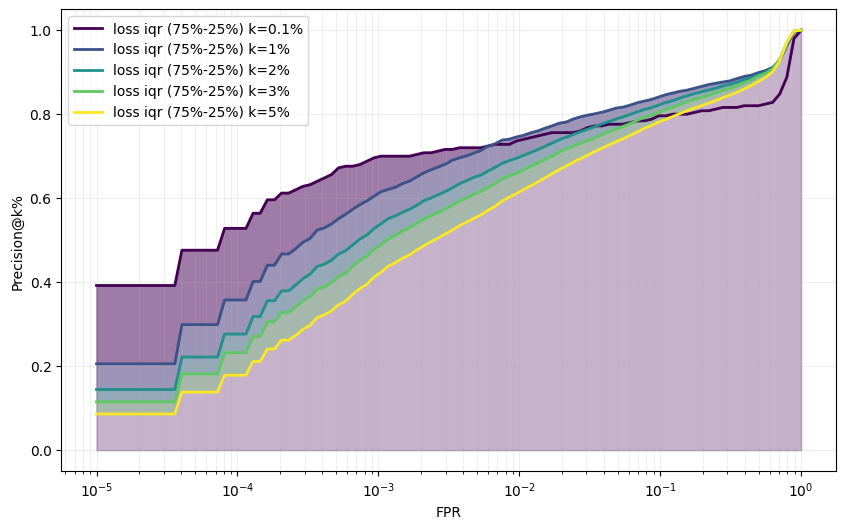

In [15]:
ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=True)

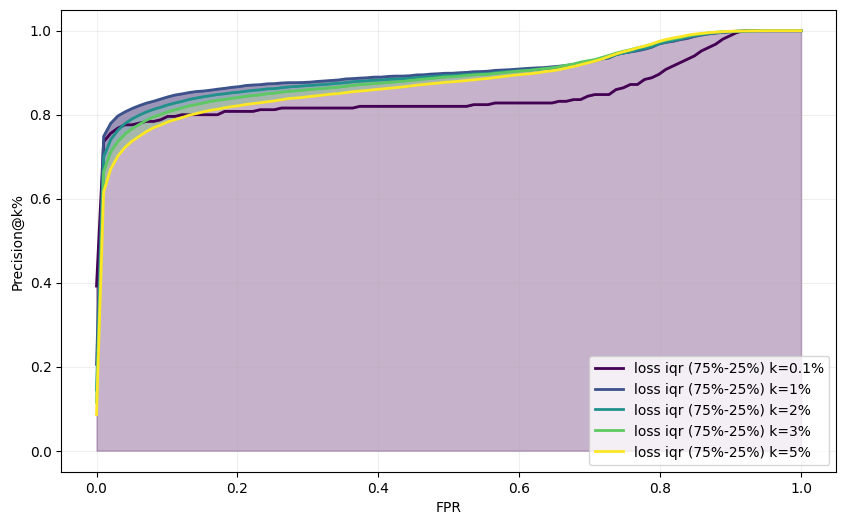

In [16]:
ks = [0.1, 1, 2, 3, 5]
levels = np.linspace(0, 1, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=False)

In [ ]:
from config import STORAGE_DIR
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from result_processing import get_lira_scores
import os
from sklearn import metrics

pcts = np.linspace(0, 1, 21)

a_pcts = [p for p in pcts if p >= 0.5]
b_pcts = [p for p in pcts if p <= 0.5]
iqr_pairs = [(a, b) for a in a_pcts for b in b_pcts]

plots = iqr_pairs 

iqr_precisions = {p: [] for p in iqr_pairs}
   
exp_id = 'wrn28-2_CIFAR10'
model_ids = ['WRN28-2']
dual_counts = [1]
   
def get_trace_reduction(exp_id: str, target_id: str = None, l: int = 0.25, r: int = 0.75, trace_type="losses"):

    base_name = exp_id + '_' + target_id if target_id else exp_id
    path = os.path.join(STORAGE_DIR, trace_type, base_name + '.pq')
    df = pd.read_parquet(path)

    return _reduction_iqr(df, l, r)
   
def _reduction_iqr(traces: pd.DataFrame, l, r) -> pd.Series:
    """Calculate interquartile range."""
    q1 = traces.quantile(r, axis=1)
    q3 = traces.quantile(l, axis=1)
    return q3 - q1

fig, axes = plt.subplots(len(exp_ids), len(plots), figsize=(1 + (5 * len(plots)),(5 * len(exp_ids))), squeeze=False)
num_bins=100
# ks = range(1,101)
# ks = np.arange(0.1, 5+.1, 0.1)
ks = [1]
for j, (left, right) in enumerate(plots):

      df = get_lira_scores(exp_id)
      df['avg_norm'] = get_trace_reduction(exp_id, l=left, r=right)

      members = df[df['target_trained_on'] == True]
      top_lira = members.sort_values('lira_score', ascending=False)
      top_score = members.sort_values('avg_norm', ascending=False)
      

      def precision_at_k(k):
         n = int(k * (len(members) / 100.0))
         fprs, tprs, _thresholds = metrics.roc_curve(df['target_trained_on'], df['lira_score'], drop_intermediate=False)
         threshold = _thresholds[np.where(fprs<=level)[0][-1]]
         # print(iqr_pairs[j], threshold)
         top_k = top_score.head(n)
         tp = sum(top_k['lira_score'] >= threshold)
         return float(tp) / len(top_k)
    
      print(left, right, iqr_pairs[j],precision_at_k(1))
      iqr_precisions[iqr_pairs[j]].append(precision_at_k(1))
      
data = np.reshape(np.array(list(iqr_precisions.values())).mean(axis=1), (len(b_pcts), len(a_pcts)))


In [ ]:
import seaborn

ax = seaborn.heatmap(data, annot=True, xticklabels=[f'{x:.2f}'for i, x in enumerate(b_pcts)], yticklabels=[f'{x:.2f}'for x in a_pcts])
ax.invert_yaxis()
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.xlabel(r'$q_1$')
plt.ylabel(r'$q_2$')